In [1]:
import modules.labelHelper as lh 
import modules.featureHelper as fh
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten,Conv1D, GlobalAveragePooling1D, MaxPooling1D,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D,Conv1D,GlobalMaxPooling1D,MaxPooling1D,average, concatenate,RepeatVector,Lambda,add,subtract,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Input, Model
from sklearn import metrics as mt
from skimage.io import imshow
from sklearn import preprocessing
from matplotlib.patches import Rectangle
from scipy.ndimage import maximum_filter1d
from keras import backend as K
from keras.layers.normalization import BatchNormalization
warnings.filterwarnings('ignore')
from modules.modelTools import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from modules.plotHelper import *
from matplotlib.patches import Rectangle
from scipy.ndimage import maximum_filter1d

Import an awesome Label helper
import an awesome feature helper


C:\Users\razer\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\razer\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\razer\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

In [2]:
ll=lh.Label('../2019_fall_labels.csv')
print("There are %d videos in total\n"%ll.video_count())
ll.get_trainee_info()

train_fold,test_fold=ll.cross_validation_on_people(5)
# print(train_fold)
# print(test_fold)

## set up feature parameters ##
folder = "../2019_fall_video_features"
video_clips_length=30
time_lag=2
move_threshold=150
stride=video_clips_length



There are 83 videos in total

There are 19 trainees in total

 Number of Videos from each person
Akhtar          -- [176 253 761] ----: 3
Cadeddu         -- [164 171] ----: 2
Crivelli        -- [225 276 333 425] ----: 4
Gahan           -- [257 345 378 384 486] ----: 5
Johnson         -- [441 615] ----: 2
Keith           -- [240 277 717] ----: 3
Kenigsberg      -- [ 78 440 455 471 881] ----: 5
Krabbe          -- [152 344 527 861] ----: 4
Marthur         -- [130 194 222 368 921] ----: 5
Mollengarden    -- [ 59 143 267 460] ----: 4
Moony           -- [294 301 361 498 539] ----: 5
Passoni         -- [207 237 895 942] ----: 4
Rozanski        -- [113 302 716] ----: 3
Satyanarayan    -- [ 16  74 236 358 436 457 503 537 557 578 599 632 689] ----: 13
Singla          -- [ 49 536 538] ----: 3
Sorokin         -- [ 91 226 507 530] ----: 4
Timburlake      -- [258 296 559 742] ----: 4
Tse             -- [ 11 283 414 427 562 928] ----: 6
Varun           -- [192 401 417 820] ----: 4


In fold 1

(2237, 30, 28)
(2237, 6)
(465, 30, 28)
(465, 6)

Epoch 00001: val_loss improved from inf to 2.18708, saving model to model_zoo/MTmodel1.h5

Epoch 00002: val_loss improved from 2.18708 to 1.79067, saving model to model_zoo/MTmodel1.h5

Epoch 00003: val_loss improved from 1.79067 to 1.59773, saving model to model_zoo/MTmodel1.h5

Epoch 00004: val_loss improved from 1.59773 to 1.45946, saving model to model_zoo/MTmodel1.h5

Epoch 00005: val_loss improved from 1.45946 to 1.39594, saving model to model_zoo/MTmodel1.h5

Epoch 00006: val_loss improved from 1.39594 to 1.18321, saving model to model_zoo/MTmodel1.h5

Epoch 00007: val_loss improved from 1.18321 to 1.04183, saving model to model_zoo/MTmodel1.h5

Epoch 00008: val_loss improved from 1.04183 to 0.78117, saving model to model_zoo/MTmodel1.h5

Epoch 00009: val_loss improved from 0.78117 to 0.75817, saving model to model_zoo/MTmodel1.h5

Epoch 00010: val_loss improved from 0.75817 to 0.66247, saving model to model_zoo/MTmodel

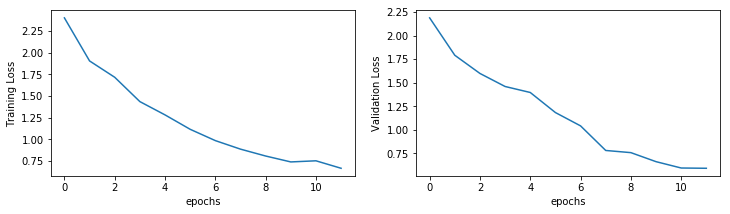

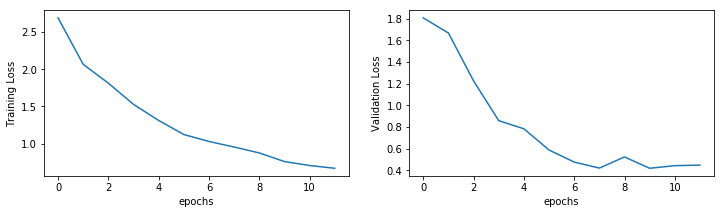

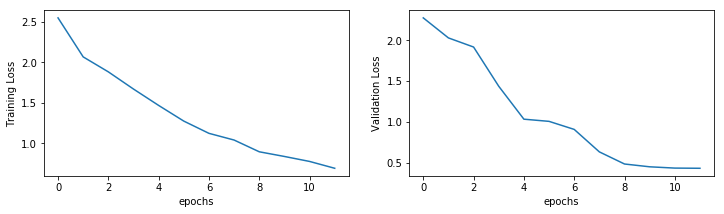

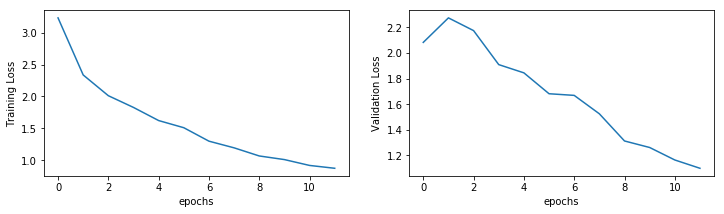

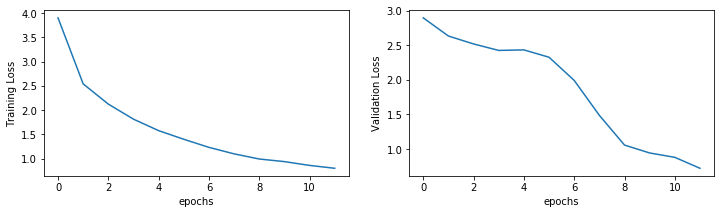

In [3]:
per_gear_score_folds=[]
filtered_per_gear_score_folds=[]

predict_label_folds=[]
filtered_predict_label_folds=[]
gt_label_folds=[]

acc=[]
filtered_acc=[]

it=1
for train_video_number,test_video_number in zip(train_fold,test_fold):
    print("In fold %d\n" %it)
    
    predict_label=[]
    filtered_predict_label=[]
    gt_label=[]
    # -----------in each fold ---------------------------------------------------
    # train test split by people
    train_video,train_video_label=fh.make_train_test_data_from_video_numbers(folder,train_video_number,video_clips_length,time_lag,move_threshold,stride,ll)
    test_video,test_video_label=fh.make_train_test_data_from_video_numbers(folder,test_video_number,video_clips_length,time_lag,move_threshold,stride,ll)
    print(train_video.shape)
    print(train_video_label.shape)
    print(test_video.shape)
    print(test_video_label.shape)
    
    # -----------pre-processing  ---------------------------------------------------
    X_train=train_video/640-0.5
    X_test=test_video/640-0.5
    y_train=train_video_label/5
    y_test=test_video_label/5

    # -----------init data generator  ---------------------------------------------------
    sample_of_trainningdata=X_train.shape[0]
    sample_of_testdata=X_test.shape[0]
    batch_size=64
    train_gen=generator(X_train, y_train, batch_size,0.1)
    val_gen=generator(X_test, y_test, batch_size,0)

    # -----------#prepare for model in&out shape ---------------------------------------------------
    clip_lenth=X_train.shape[1]
    dimension=X_train.shape[2]
    l2_lambda=0.01
    model=make_model(0.01,clip_lenth,dimension)

    callbacks_list = get_callback_list_by_model('MTmodel'+str(it))
    
    model_h=model.fit_generator(train_gen,
                        steps_per_epoch=sample_of_trainningdata//batch_size,
                        epochs=12,
                        validation_data=val_gen,
                       validation_steps=sample_of_testdata//batch_size,
                        verbose=0,
                        callbacks=callbacks_list
     )
    
    # -----------#plot training results ---------------------------------------------------
    ax=plt.figure(figsize=(12,14))
    ax = plt.subplot(421)
    ax.plot(model_h.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    ax = plt.subplot(422)
    ax.plot(model_h.history['val_loss'])
    plt.ylabel('Validation Loss')
    plt.xlabel('epochs')
    model.load_weights('model_zoo/MTmodel{}.h5'.format(str(it)))
    
    # -----------calcuate pre gear score acc and category prediction---------------------------------------------------
    valid_arr=np.zeros(6)
    filtered_valid_arr=np.zeros(6)
    for t_number in test_video_number:
        re,gt = model_predit_by_videoNumber(model,folder,t_number,video_clips_length,time_lag,move_threshold,stride,ll) 
        
        #-------------max filter data
        filtered_data=pd.DataFrame(re,columns=['DP','BD','E','FS','A','RC'])
        for index, row in filtered_data.iteritems():
            filtered_data[index]=maximum_filter1d(filtered_data[index],mode='nearest',size= 3)
        #-------------max filter data
#         print(re)
#         print(filtered_data)
        #-------------category prediction
        predict_level,predict_totalScore=convert_to_skill(re,'mean')
        filter_predict_level,filter_predict_totalScore=convert_to_skill(filtered_data,'mean')
        gt_level,gt_totalScore=ll.get_video_level_by_video_number(t_number,'mean')

#         print("Predict vs GT level:",predict_level,gt_level)
#         print("Predict Score vs filter_predict_level Score:",predict_totalScore,filter_predict_totalScore)
        predict_label.append(predict_level)
        filtered_predict_label.append(filter_predict_level)
        gt_label.append(gt_level)
        
        #-------------category prediction
        
        #-------------pre gear score acc 
        filtered_re=np.round(np.mean(filtered_data,axis=0))
        re=np.round(np.mean(re,axis=0))
        
        score_range=ll.get_video_score_range_by_video_number(t_number)
        maxScore=score_range[0]
        minScore=score_range[1]
        for index,val in enumerate(['DP','BD','E','FS','A','RC']):
            if re[index]>=int(minScore[val]) and re[index]<=int(maxScore[val]):
                valid_arr[index]+=1
            if filtered_re[index]>=int(minScore[val]) and filtered_re[index]<=int(maxScore[val]):
                filtered_valid_arr[index]+=1
#             print(re[index], filtered_valid_arr[index])
        #-------------pre gear score acc 
        
    predict_label_folds.append(predict_label)
    filtered_predict_label_folds.append(filtered_predict_label)
    gt_label_folds.append(gt_label)  
    acc.append(sum(np.array(predict_label)==np.array(gt_label))/len(predict_label))
    filtered_acc.append(sum(np.array(filtered_predict_label)==np.array(gt_label))/len(predict_label))
    
    per_gear_score_folds.append(valid_arr/len(test_video_number))
    filtered_per_gear_score_folds.append(filtered_valid_arr/len(test_video_number))
    it+=1
        

In [4]:
print(per_gear_score_folds)
print(filtered_per_gear_score_folds)



[array([0.64285714, 0.35714286, 0.42857143, 0.35714286, 0.42857143,
       0.35714286]), array([0.64285714, 0.64285714, 0.64285714, 0.57142857, 0.64285714,
       0.57142857]), array([0.77777778, 0.5       , 0.55555556, 0.44444444, 0.72222222,
       0.5       ]), array([0.52173913, 0.52173913, 0.52173913, 0.56521739, 0.60869565,
       0.52173913]), array([0.64285714, 0.64285714, 0.64285714, 0.5       , 0.42857143,
       0.64285714])]
[array([0.64285714, 0.35714286, 0.42857143, 0.35714286, 0.42857143,
       0.35714286]), array([0.64285714, 0.64285714, 0.64285714, 0.57142857, 0.64285714,
       0.57142857]), array([0.77777778, 0.5       , 0.55555556, 0.44444444, 0.72222222,
       0.5       ]), array([0.52173913, 0.52173913, 0.52173913, 0.56521739, 0.60869565,
       0.52173913]), array([0.64285714, 0.64285714, 0.64285714, 0.5       , 0.42857143,
       0.64285714])]


In [5]:
print(predict_label_folds)
print(filtered_predict_label_folds)
print(gt_label_folds)


[[1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2], [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], [2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1]]
[[1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2], [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], [2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1]]
[[0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 2, 2, 2], [1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2], [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1], [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1], [2, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2]]


In [6]:

print(acc)
print(filtered_acc)

[0.5, 0.5714285714285714, 0.3888888888888889, 0.43478260869565216, 0.42857142857142855]
[0.5, 0.5714285714285714, 0.3888888888888889, 0.43478260869565216, 0.42857142857142855]
